In [1]:
using Plots

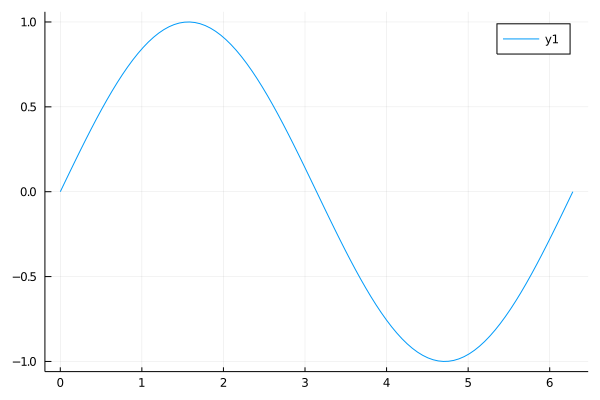

In [2]:
x = [range(0, stop=2π, length=100)...]
y = sin.(x)

plot(x, y)

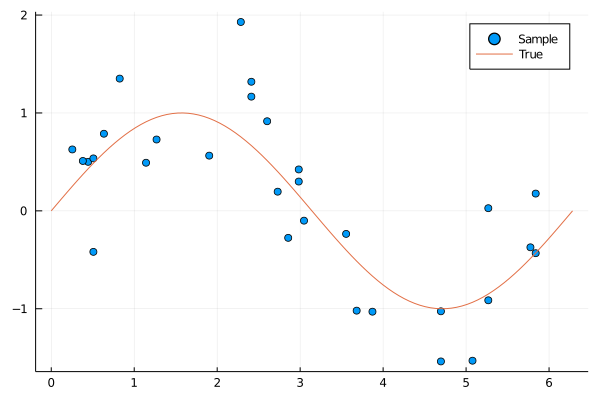

In [3]:
using Random, Distributions, StatsBase

N = 30

rng = MersenneTwister(0)
x_sample = sample(rng, x, N)
y_sample = sin.(x_sample) + 0.5 * randn(rng, N)

scatter(x_sample, y_sample, label="Sample")
plot!(x, y, label="True")

In [4]:
using LinearAlgebra


abstract type LinearModel end


mutable struct Ridge <: LinearModel
    coef::Array{Float64, 1}
    λ::Float64
    Ridge(;λ=0.1) = new([], λ) 
end


mutable struct Lasso <: LinearModel
    coef::Array{Float64, 1}
    λ::Float64
    max_iter::UInt64
    ε::Float64
    Lasso(;λ=0.1, max_iter=1000, ε=1e-5) = new([], λ, max_iter, ε)
end


function predict(model::LinearModel, X::Array{Float64, 2})::Array{Float64, 1}
    X * model.coef
end


function fit(model::Ridge, X::Array{Float64, 2}, y::Array{Float64, 1})
    model.coef = inv(X' * X + model.λ * I) * X' * y
end

fit (generic function with 1 method)

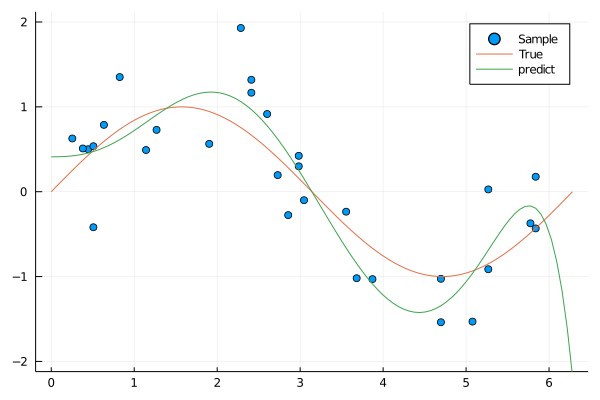

In [12]:
φ(x::Float64, M::Int)::Array{Float64, 1} = [x^i for i = 0:M]
Φ(X::Array{Float64, 1}, M::Int)::Array{Float64, 2} = hcat([φ(x, M) for x in X]...)'

M = 10
X_sample = Φ(x_sample, M-1)

ridge = Ridge(λ=0.1)
fit(ridge, X_sample, y_sample)

X = Φ(x, M-1)
y_ridge = predict(ridge, X)

scatter(x_sample, y_sample, label="Sample")
plot!(x, y, label="True")
plot!(x, y_ridge, label="predict")
plot!(ylims=[-2, 2])

In [13]:
function ST(α::Float64, β::Float64)::Float64
    if α > β
        α - β
    elseif α <  - β
        α + β
    else
        0
    end
end

function fit(
        model::Lasso,
        X::Array{Float64, 2},
        y::Array{Float64, 1},
    )
    _, M = size(X)
    
    # initialize
    model.coef = zeros(M)
    w_norm_old = norm(model.coef)
    
    for k = 1:model.max_iter
        for m = 1:M
            _m = fill(true, M)
            _m[m] = false
            
            α = X[:, m]' * (y - X[:, _m] * model.coef[_m])
            model.coef[m] = ST(α, model.λ) / (X[:, m]' * X[:, m])
        end
        
        # check convergence
        w_norm_new = norm(model.coef)
        if abs(w_norm_new - w_norm_old) < model.ε
            return
        end
        w_norm_old = w_norm_new
    end
end

fit (generic function with 2 methods)

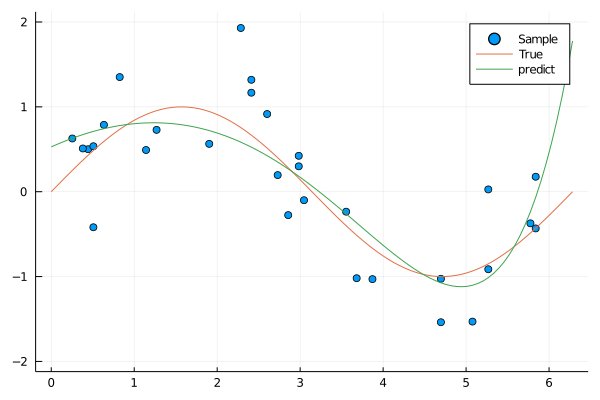

In [14]:
lasso = Lasso(λ=0.1, max_iter=1000, ε=1e-5)
fit(lasso, X_sample, y_sample)
y_lasso = predict(lasso, X)

scatter(x_sample, y_sample, label="Sample")
plot!(x, y, label="True")
plot!(x, y_lasso, label="predict")
plot!(ylims=[-2, 2])

In [15]:
λs = range(1e-4, 1e3, length=10000)
ridge_coefs = zeros(M, 10000) 
lasso_coefs = zeros(M, 10000) 
for i = 1:100
    ridge = Ridge(λ=λs[i])
    fit(ridge, X_sample, y_sample)
    
    lasso = Lasso(λ=λs[i], max_iter=10)
    fit(lasso, X_sample, y_sample)
    
    ridge_coefs[:, i] = copy(ridge.coef)
    lasso_coefs[:, i] = copy(lasso.coef)
end

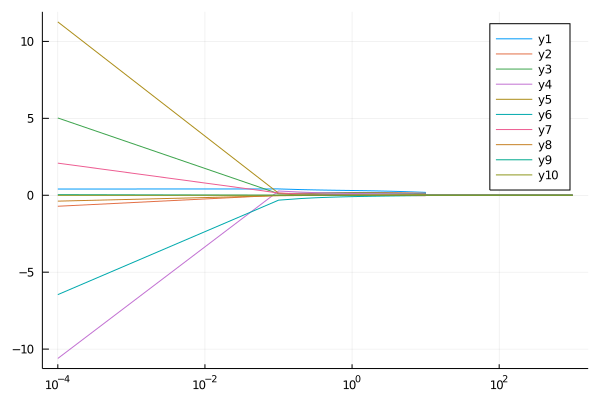

In [16]:
p = plot()
for i = 1:M
    plot!(p, λs, ridge_coefs[i, :], xaxis=:log)
end
p

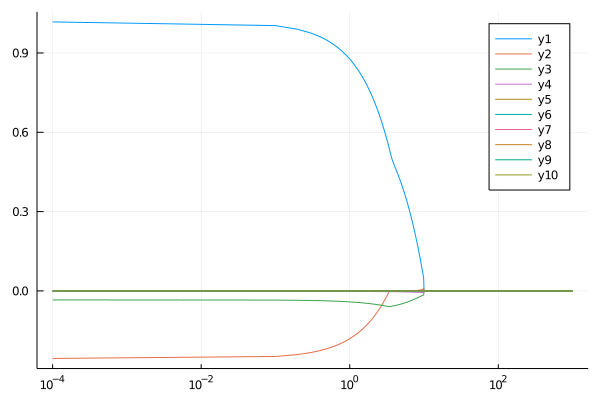

In [17]:
p = plot()
for i = 1:M
    plot!(p, λs, lasso_coefs[i, :], xaxis=:log)
end
p